In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy.stats import norm


%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:
#importing data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

C:\Users\malco\AppData\Local\Temp\ipykernel_29684\2082211807.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], fit=norm);


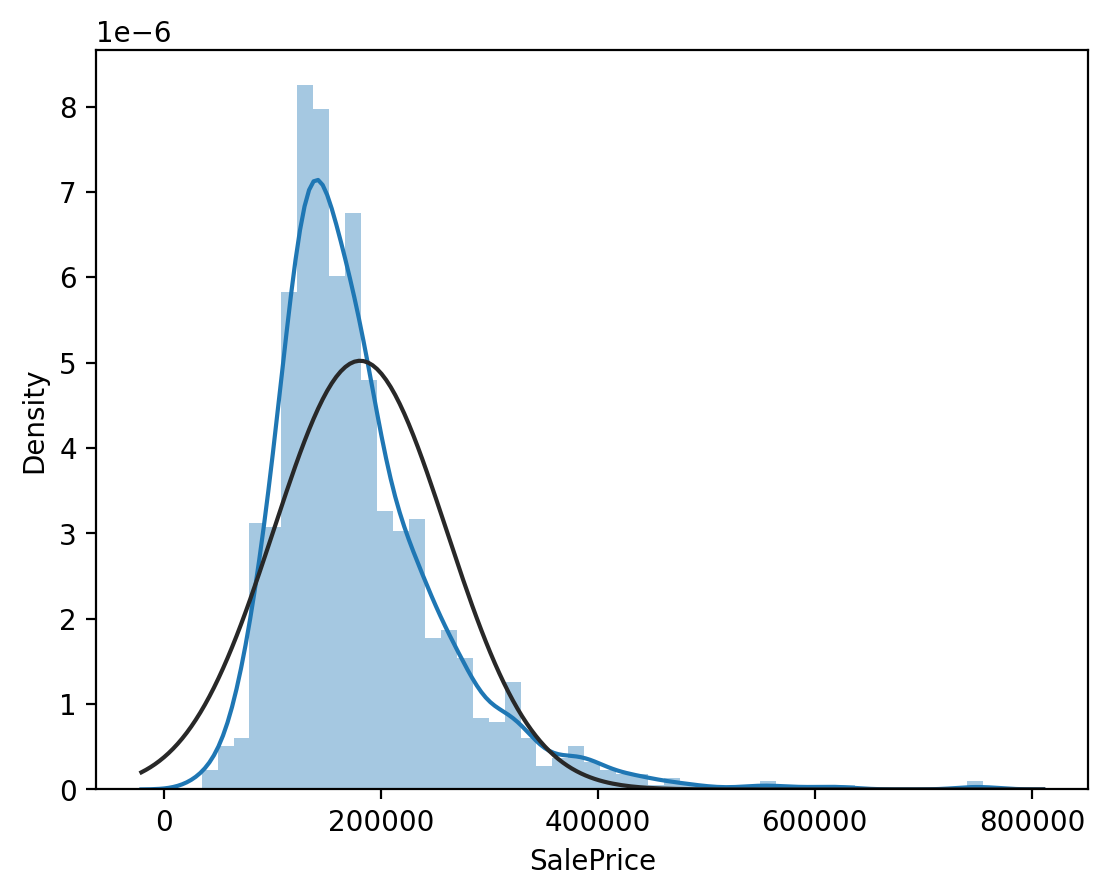

In [3]:
#exploratory plots
sns.distplot(train['SalePrice'], fit=norm);

Significant right skewness

C:\Users\malco\AppData\Local\Temp\ipykernel_29684\964630943.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], fit=norm, axlabel="Log Sales Price");


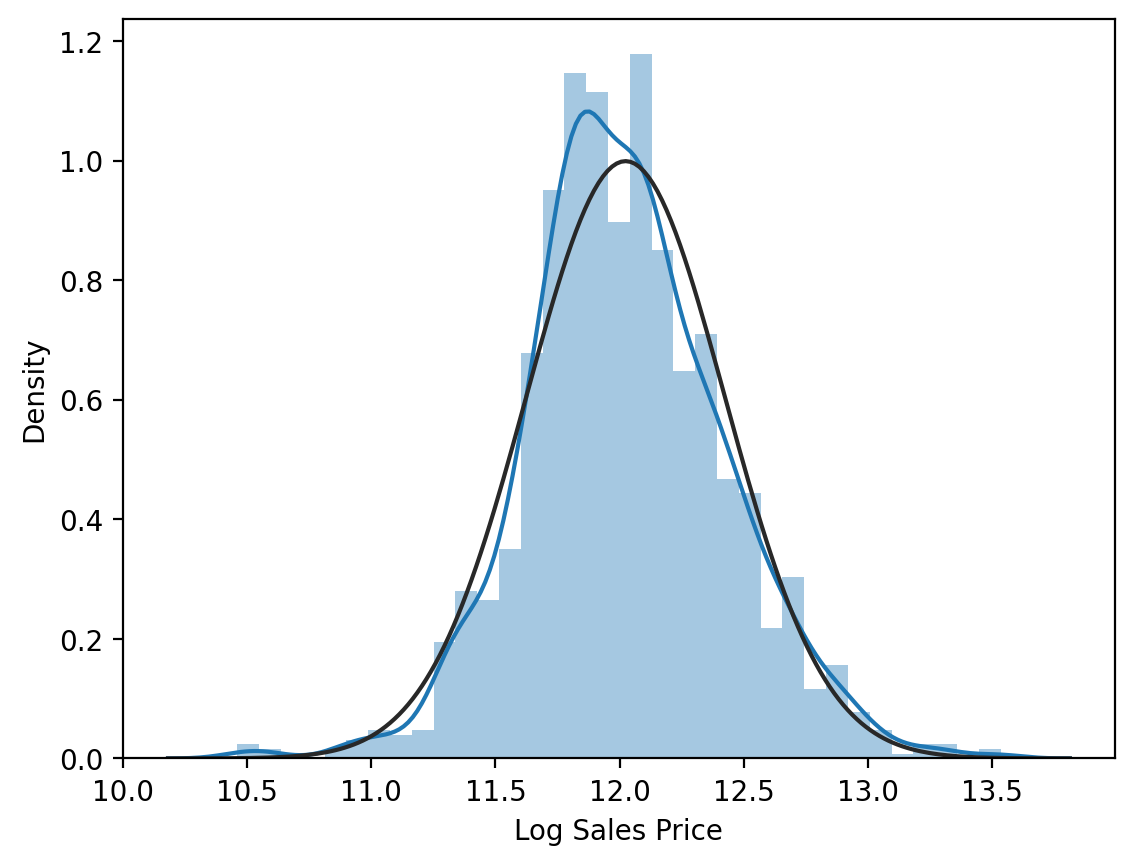

In [4]:
#Log transform for skewed numeric features

train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
sns.distplot(train['SalePrice'], fit=norm, axlabel="Log Sales Price");

In [5]:
#creating dummeis
all_data = pd.get_dummies(all_data)
#replacing NAs with mean of column
all_data = all_data.fillna(all_data.mean())
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [6]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#function to return rmse to evaluate models
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()

Text(0, 0.5, 'rmse')

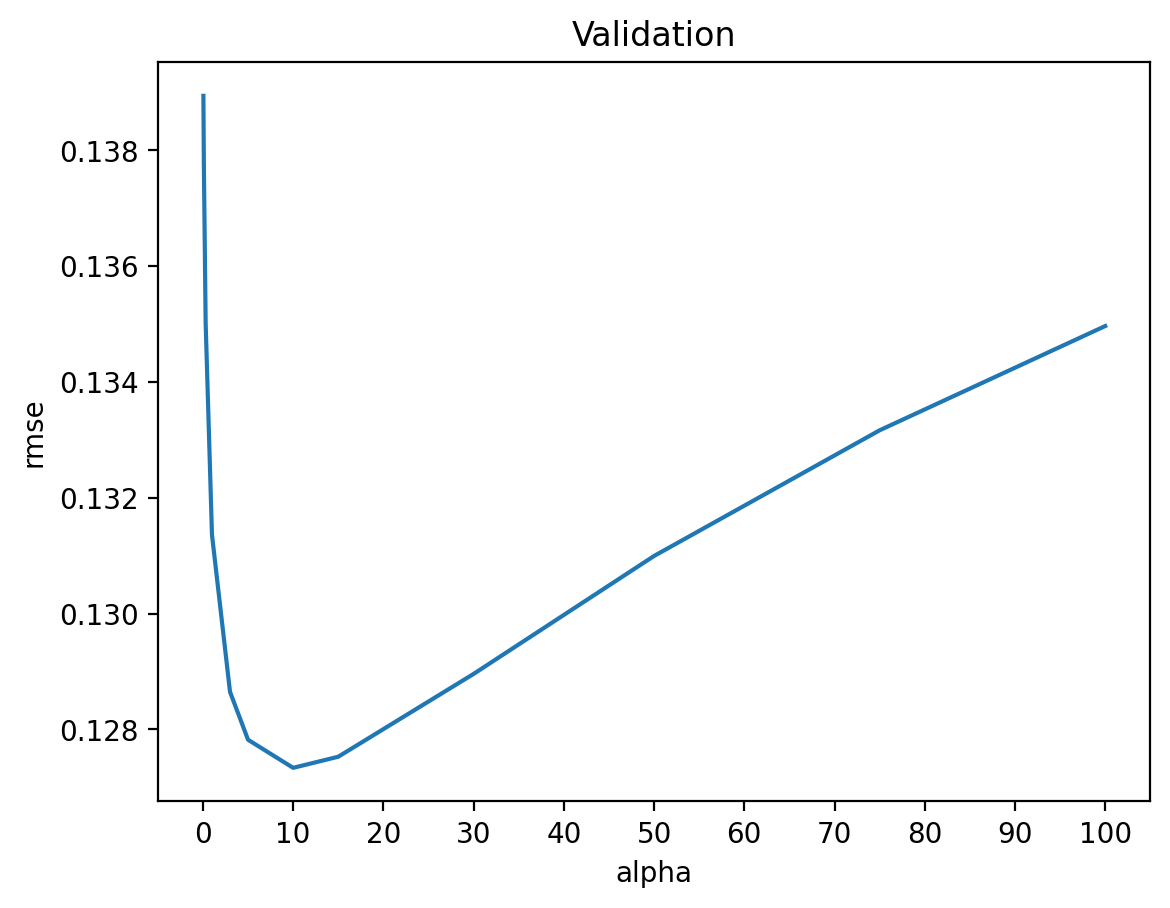

In [7]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.xlabel("alpha")
plt.ylabel("rmse")

When alpha is too large the regularization is too strong and the model cannot capture all the complexities. If alpha is too small, the model begins to overfit. The optimal alpha is around 10, from the plot above.

In [8]:
min_rmse_ridge = cv_ridge.min()

print(f"RMSE for Ridge regression: {min_rmse_ridge}")

RMSE for Ridge regression: 0.12733734668670765


In [9]:

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

rmse_lasso = rmse_cv(model_lasso).mean()

print(f"RMSE for Lasso regression: {rmse_lasso}")

RMSE for Lasso regression: 0.12256735885048142


Lasso is preferred

In [10]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


Text(0.5, 1.0, '20 most important coefficients in the Lasso Model')

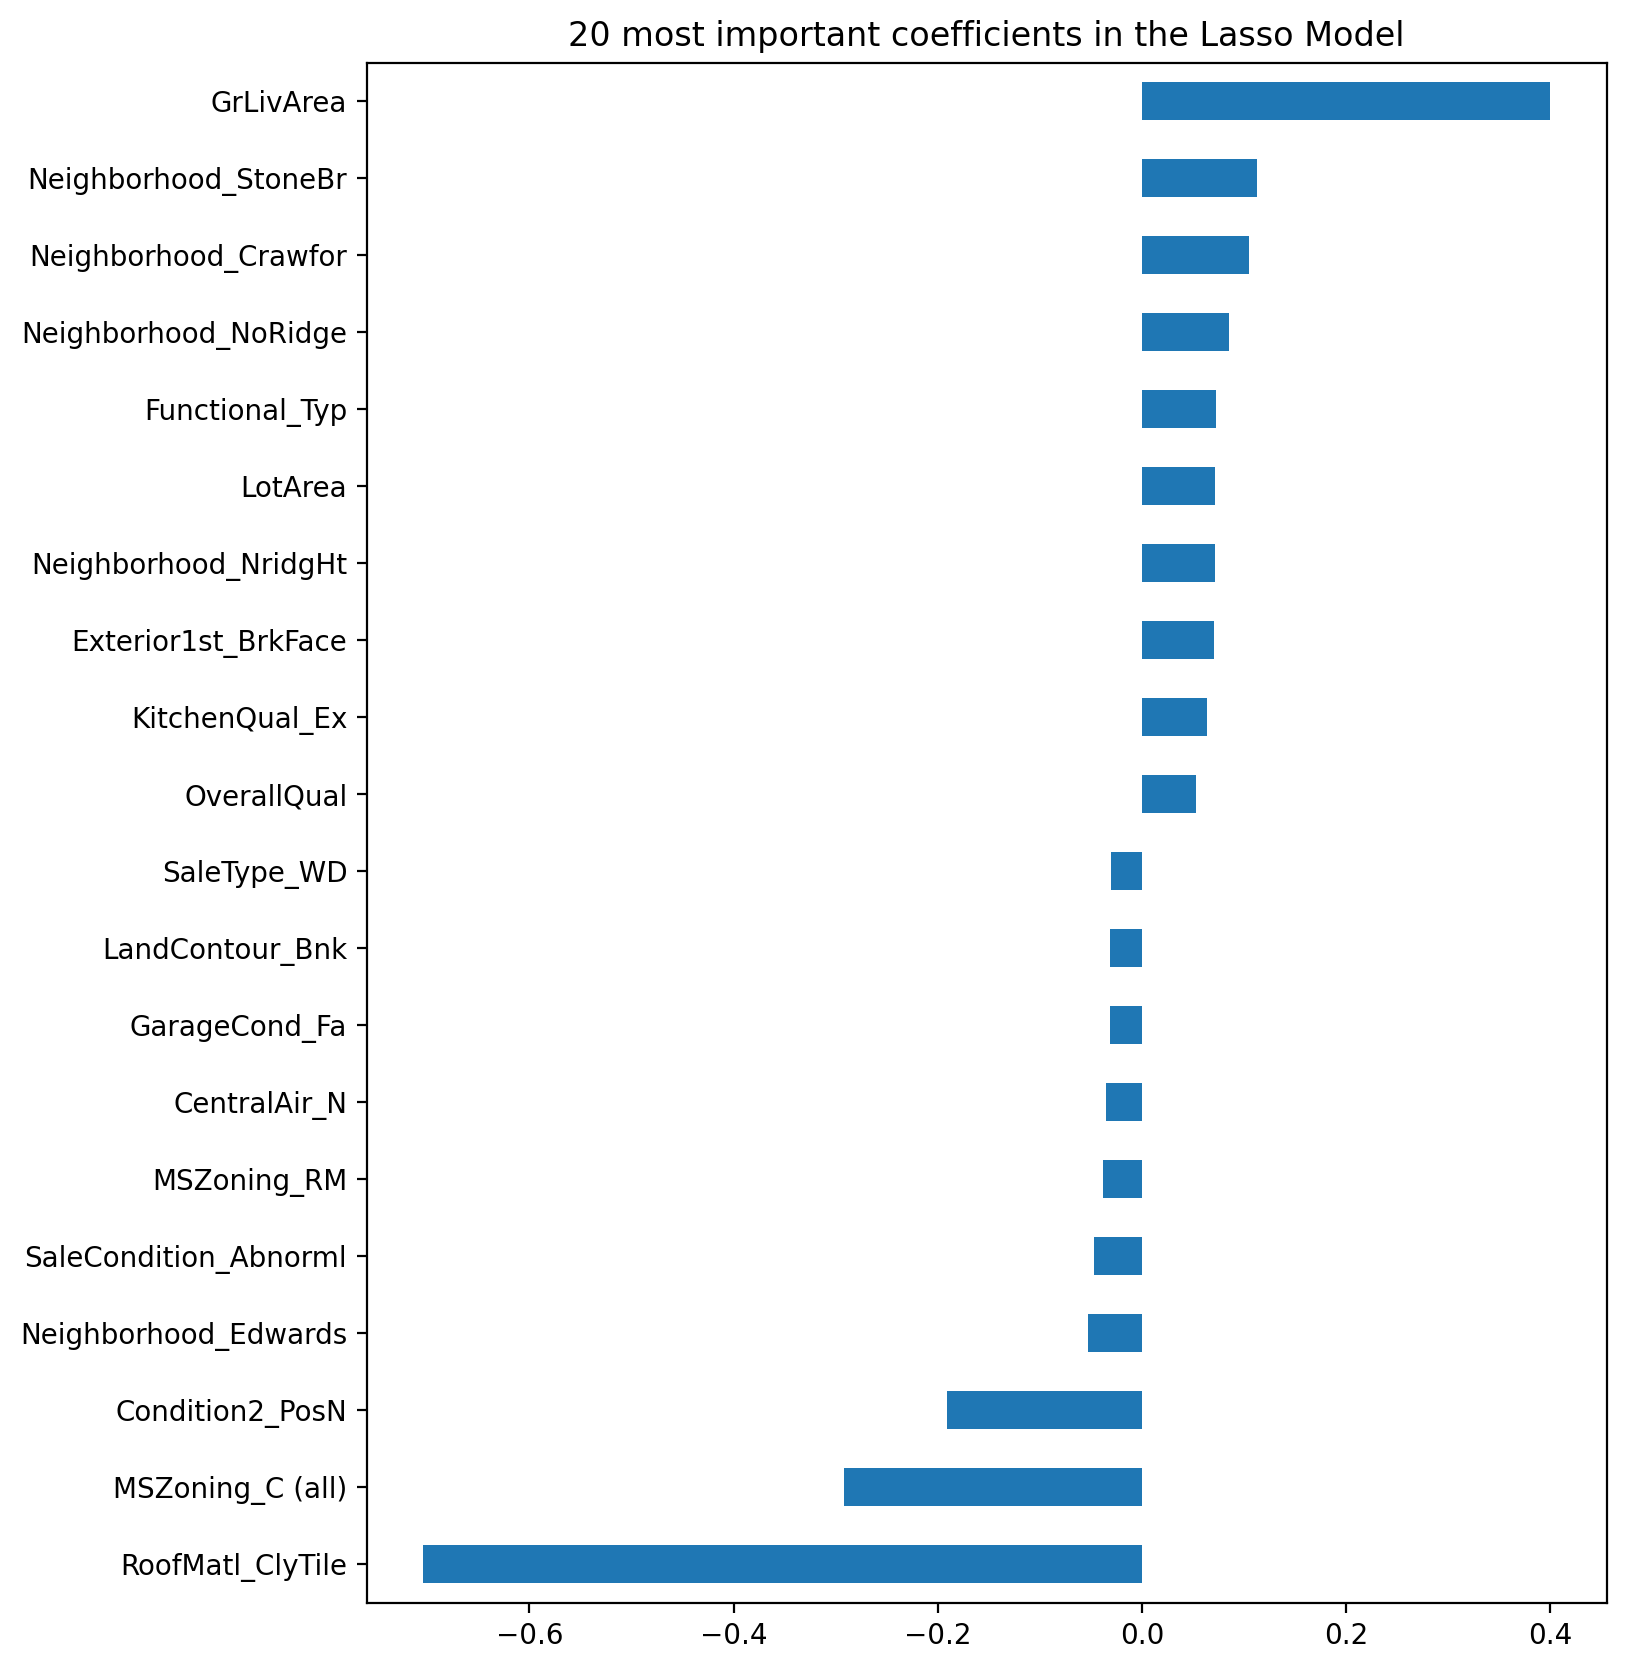

In [11]:
#identifying the most important coeffcients
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("20 most important coefficients in the Lasso Model")

The most important positive feature is GrLivArea, while the most important negative feature is RoofMatl_ClyTile

c:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='preds', ylabel='residuals'>

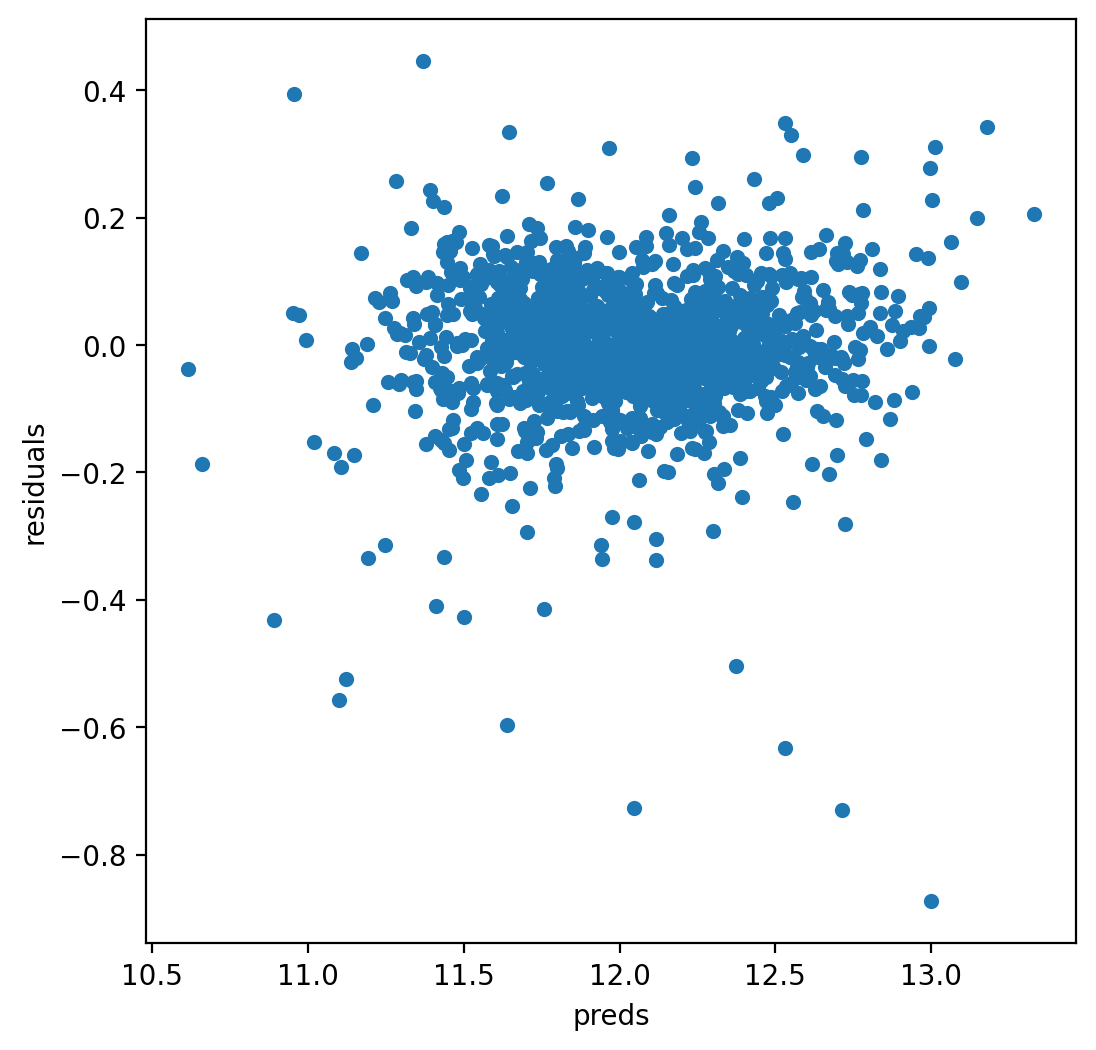

In [12]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

residuals appear randomly distributed, no heteroskedasticity

In [13]:
#gradient boosting to improve performance
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)
xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds
#final model
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
#final model to csv
solution.to_csv("ridge_sol.csv", index = False)
